Pneumonia is a lung inflammatory illness that mostly affects the little air sacs known as alveoli. Typical symptoms include a productive or dry cough, chest discomfort, fever, and trouble breathing. The severity of the condition is variable. Pneumonia is usually caused by infection with viruses or bacteria and less commonly by other microorganisms, certain medications or conditions such as autoimmune diseases. Risk factors include cystic fibrosis, chronic obstructive pulmonary disease (COPD), asthma, diabetes, heart failure, a history of smoking, a poor ability to cough such as following a stroke and a weak immune system. Diagnosis is often based on symptoms and physical examination. Chest X-ray, blood tests, and culture of the sputum may help confirm the diagnosis.

This Mini Project focuses on a classification model that can classify pneumonia from chest xray.


$Dataset name$ - Chest X-Ray Images (Pneumonia)


$number of records$ - 5856

$Description$ - The dataset is organized into 3 folders (train, test, val) and contains subfolders for each image category (Pneumonia/Normal). There are 5,863 X-Ray images (JPEG) and 2 categories (Pneumonia/Normal).


Chest X-ray images (anterior-posterior) were selected from retrospective cohorts of pediatric patients of one to five years old from Guangzhou Women and Children’s Medical Center, Guangzhou. All chest X-ray imaging was performed as part of patients’ routine clinical care.

For the analysis of chest x-ray images, all chest radiographs were initially screened for quality control by removing all low quality or unreadable scans. The diagnoses for the images were then graded by two expert physicians before being cleared for training the AI system. In order to account for any grading errors, the evaluation set was also checked by a third expert.

$Public dataset or not$ - Public Dataset

Dataset link - https://www.kaggle.com/paultimothymooney/chest-xray-pneumonia


## Import Nessessary Libraries

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib import ticker
from random import sample, seed
from seaborn import heatmap
from sklearn.utils import class_weight
from sklearn.metrics import roc_auc_score, roc_curve, auc
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import InceptionResNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import AUC
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.math import confusion_matrix

Understanding the nature of the dataset

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
dataset_path = '/content/drive/MyDrive/Longitivity/chest_xray/'

def sets_sizes():
  for df_folder in ["train", "val", "test"]:
    print(df_folder)
    for img_class in ["NORMAL", "PNEUMONIA"]:
      files = next(os.walk(dataset_path + df_folder + "/" + img_class))[2]
      print(img_class + ": " + str(len(files)))
    print()

sets_sizes()

train
NORMAL: 441
PNEUMONIA: 1271

val
NORMAL: 908
PNEUMONIA: 2612

test
NORMAL: 234
PNEUMONIA: 390



Merge the dataset in the sub folders

In [ ]:
train_path = dataset_path + "train/"
valid_path = dataset_path + "val/"
test_path = dataset_path + "test/"

path_normal = train_path + "NORMAL/"
files_normal = next(os.walk(train_path + "NORMAL"))[2]

path_pneumonia = train_path + "PNEUMONIA/"
files_pneumonia = next(os.walk(train_path + "PNEUMONIA"))[2]

seed(123)
normal_to_val = sample(files_normal, int(len(files_normal) * 0.2))
pneumonia_to_val = sample(files_pneumonia, int(len(files_pneumonia) * 0.2))

def move_file(file_list, source_folder, destination_folder):
  for filename in file_list:
    file_to_move = source_folder + "/" + filename
    !mv $file_to_move $destination_folder

move_file(normal_to_val, path_normal, valid_path + "NORMAL")
move_file(pneumonia_to_val, path_pneumonia, valid_path + "PNEUMONIA")

sets_sizes()

train
NORMAL: 353
PNEUMONIA: 1017

val
NORMAL: 996
PNEUMONIA: 2866

test
NORMAL: 234
PNEUMONIA: 390



Preview the dataset

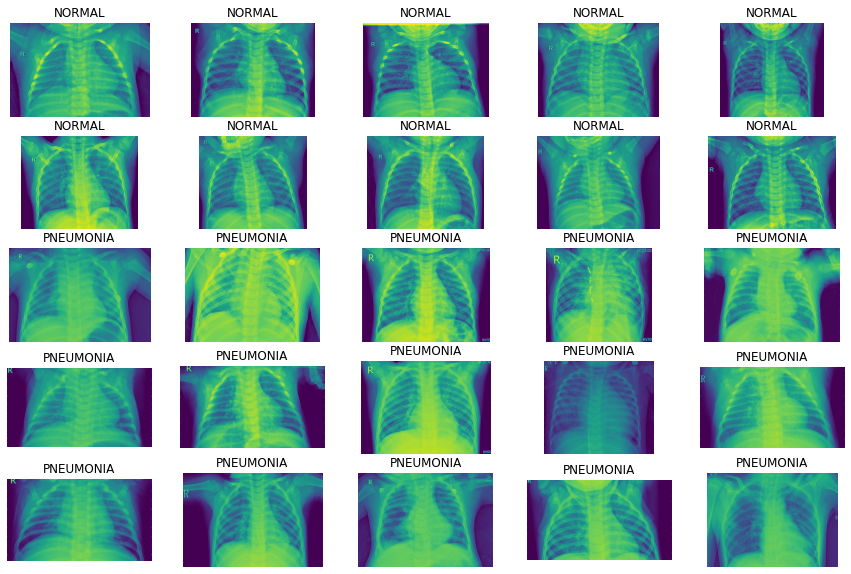

In [ ]:
files_normal = next(os.walk(train_path + "NORMAL"))[2]
files_pneumonia = next(os.walk(train_path + "PNEUMONIA"))[2]

fig, axes = plt.subplots(5, 5, figsize = (15, 10))
axes = axes.ravel()

for i in range(0, 25):
  if i<10:
    img = mpimg.imread(path_normal + files_normal[i])
    axes[i].set_title("NORMAL")
  else:
    img = mpimg.imread(path_pneumonia + files_pneumonia[i])
    axes[i].set_title("PNEUMONIA")

  axes[i].imshow(img)
  axes[i].axis("off")

plt.show()

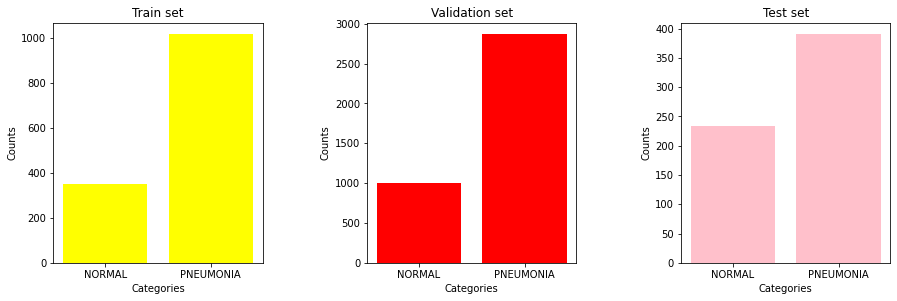

In [ ]:
plt.figure(figsize=(15, 15))

plt.subplot(3, 3, 1)
plt.bar(x=range(0,2), height = [len(next(os.walk(train_path + "NORMAL"))[2]), len(next(os.walk(train_path + "PNEUMONIA"))[2])],
        tick_label=["NORMAL", "PNEUMONIA"], color = "yellow")
plt.title("Train set")
plt.xlabel("Categories")
plt.ylabel("Counts")

plt.subplot(3, 3, 2)
plt.bar(x=range(0,2), height = [len(next(os.walk(valid_path + "NORMAL"))[2]), len(next(os.walk(valid_path + "PNEUMONIA"))[2])],
        tick_label=["NORMAL", "PNEUMONIA"], color = "red")
plt.title("Validation set")
plt.xlabel("Categories")
plt.ylabel("Counts")

plt.subplot(3, 3, 3)
plt.bar(x=range(0,2), height = [len(next(os.walk(test_path + "NORMAL"))[2]), len(next(os.walk(test_path + "PNEUMONIA"))[2])],
        tick_label=["NORMAL", "PNEUMONIA"], color = "pink")
plt.title("Test set")
plt.xlabel("Categories")
plt.ylabel("Counts")

plt.subplots_adjust(wspace=0.5)
plt.show()

In [ ]:
train_batch_size = 64
valid_batch_size = 64
test_batch_size = 32
image_h = 224
image_w = 224

train_datagen = ImageDataGenerator(rescale=1/255.,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True,
                                   vertical_flip=False)

train_generator = train_datagen.flow_from_directory(directory=train_path,
                                                    target_size=(image_h, image_w),
                                                    batch_size=train_batch_size,
                                                    classes=["NORMAL", "PNEUMONIA"],
                                                    class_mode="binary")

valid_datagen = ImageDataGenerator(rescale=1/255.)
valid_generator = valid_datagen.flow_from_directory(directory=valid_path,
                                                    target_size=(image_h, image_w),
                                                    batch_size=valid_batch_size,
                                                    classes=["NORMAL", "PNEUMONIA"],
                                                    class_mode="binary")

test_datagen = ImageDataGenerator(rescale=1/255.)
test_generator = test_datagen.flow_from_directory(directory=test_path,
                                                  target_size=(image_h, image_w),
                                                  batch_size=test_batch_size,
                                                  classes=["NORMAL", "PNEUMONIA"],
                                                  class_mode="binary",
                                                  shuffle = False,
                                                  seed=42)


Found 1370 images belonging to 2 classes.
Found 3862 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [ ]:
base_model = InceptionResNetV2(include_top=False, weights="imagenet", input_shape=(image_h, image_w, 3))

219070464/219055592 [==============================] - 5s 0us/step


In [ ]:
base_model.summary()

Model: "inception_resnet_v2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 111, 111, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 111, 111, 32  96         ['conv2d[0][0]']                 
 alization)                     )                                               

In [ ]:
base_model.trainable = False

In [ ]:
x = base_model.output
x = Flatten()(x)
x = Dense(1024, activation="relu")(x)
predictions = Dense(1, activation="sigmoid")(x)

model = Model(inputs=base_model.input, outputs=predictions)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 111, 111, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 111, 111, 32  96         ['conv2d[0][0]']                 
 alization)                     )                                                             

In [ ]:
model.compile(optimizer=Adam(learning_rate=0.001), loss="binary_crossentropy", metrics=["accuracy", AUC(name="auc")])

learning_control = ReduceLROnPlateau(monitor="val_loss", patience=5, verbose=1, factor=0.1, min_lr=0.000001)

early_stopping = EarlyStopping(monitor="val_loss", min_delta=0, patience=15, verbose=1, mode="auto")

history = model.fit(x = train_generator,
                    validation_data=valid_generator,
                    epochs=20,
                    callbacks=[learning_control, early_stopping])

Epoch 1/20
22/22 [==============================] - 2211s 103s/step - loss: 11.0328 - accuracy: 0.7766 - auc: 0.7232 - val_loss: 2.5089 - val_accuracy: 0.8589 - val_auc: 0.9050 - lr: 0.0010
Epoch 2/20
22/22 [==============================] - 102s 5s/step - loss: 2.4602 - accuracy: 0.8847 - auc: 0.8769 - val_loss: 1.2448 - val_accuracy: 0.9104 - val_auc: 0.9392 - lr: 0.0010
Epoch 3/20
22/22 [==============================] - 101s 5s/step - loss: 1.0424 - accuracy: 0.9241 - auc: 0.9212 - val_loss: 0.4953 - val_accuracy: 0.9490 - val_auc: 0.9561 - lr: 0.0010
Epoch 4/20
22/22 [==============================] - 100s 5s/step - loss: 0.7430 - accuracy: 0.9255 - auc: 0.9344 - val_loss: 0.6125 - val_accuracy: 0.9363 - val_auc: 0.9637 - lr: 0.0010
Epoch 5/20
22/22 [==============================] - 100s 5s/step - loss: 0.8724 - accuracy: 0.9146 - auc: 0.9230 - val_loss: 0.8650 - val_accuracy: 0.9190 - val_auc: 0.9601 - lr: 0.0010
Epoch 6/20
22/22 [==============================] - 100s 5s/step -

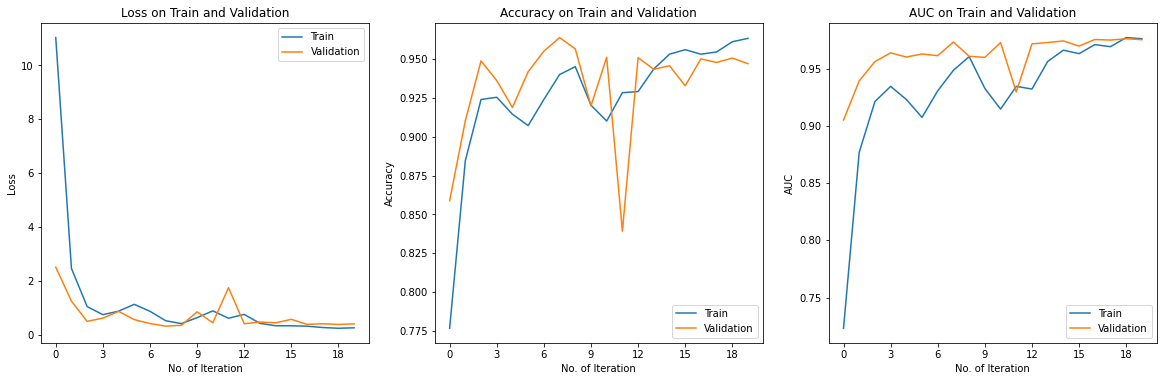

In [ ]:
plt.figure(figsize=(20, 20))

plt.subplot(3, 3, 1)
plt.plot(history.history["loss"], label="Train")
plt.plot(history.history["val_loss"], label="Validation")
plt.gca().xaxis.set_major_locator(ticker.MaxNLocator(integer=True))
plt.xlabel("No. of Iteration")
plt.ylabel("Loss")
plt.legend()
plt.title("Loss on Train and Validation")

plt.subplot(3, 3, 2)
plt.plot(history.history["accuracy"], label="Train")
plt.plot(history.history["val_accuracy"], label="Validation")
plt.gca().xaxis.set_major_locator(ticker.MaxNLocator(integer=True))
plt.xlabel("No. of Iteration")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Accuracy on Train and Validation")

plt.subplot(3, 3, 3)
plt.plot(history.history["auc"], label="Train")
plt.plot(history.history["val_auc"], label="Validation")
plt.gca().xaxis.set_major_locator(ticker.MaxNLocator(integer=True))
plt.xlabel("No. of Iteration")
plt.ylabel("AUC")
plt.legend()
plt.title("AUC on Train and Validation")

plt.show()


In [ ]:
print("AUC on train:", model.evaluate(x=train_generator, verbose=0)[2])
print("AUC on validation:", model.evaluate(x=valid_generator, verbose=0)[2])

AUC on train: 0.978734016418457
AUC on validation: 0.9752139449119568


In [ ]:
y_pred = model.predict(test_generator)
y_test = test_generator.classes
auc_test = roc_auc_score(y_test, y_pred)
print("AUC on test:", auc_test)

AUC on test: 0.9556432171816787


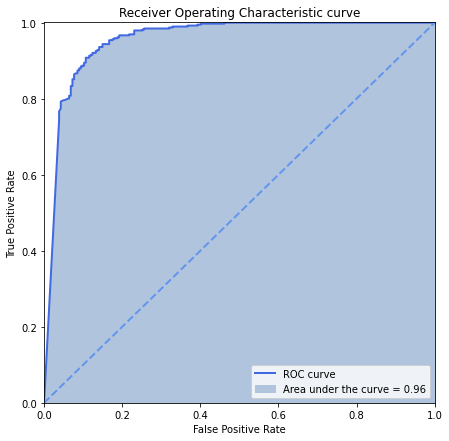

In [ ]:
fpr , tpr , thresholds = roc_curve (y_test, y_pred)
auc_keras = auc(fpr, tpr)

plt.figure(figsize=(7, 7))
line_width = 2
plt.plot(fpr, tpr, color="royalblue",
         lw=line_width, label="ROC curve")
plt.fill_between(x=fpr, y1=0, y2=tpr, color="lightsteelblue", label="Area under the curve = %0.2f" % auc_keras)
plt.plot([0, 1], [0, 1], color="cornflowerblue", lw=line_width, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.001])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic curve")
plt.legend(loc="lower right")
plt.show()

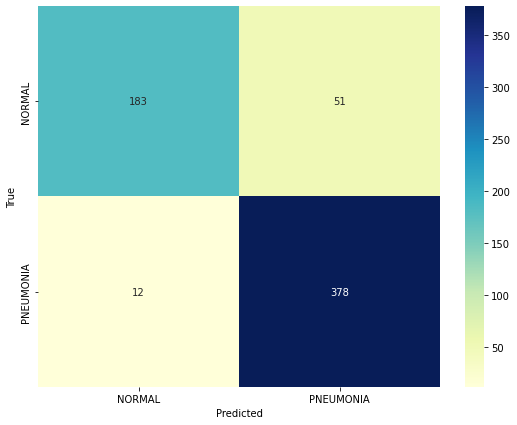

In [ ]:
threshold = 0.5
pred_test = (y_pred > threshold).astype("float")
cf_matrix = confusion_matrix(labels=y_test, predictions=pred_test)

fig, ax = plt.subplots(figsize=(9, 7))
heatmap(cf_matrix, annot=True, fmt="g", cmap="YlGnBu", xticklabels=["NORMAL", "PNEUMONIA"], yticklabels=["NORMAL", "PNEUMONIA"], )
plt.ylabel("True")
plt.xlabel("Predicted")
plt.show()